# Предобработка данных и логистическая регрессия

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
from matplotlib import pyplot as plt

matplotlib.style.use("ggplot")
%matplotlib inline

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Данные

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам, которые были поданы в университете Мельбурна с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [12]:
data = pd.read_csv(
    "/content/drive/MyDrive/Занятия. Осенний семестр/Лекции и семинары/Лекция 4/data.csv"
)
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y.
Теперь X обозначает обучающую выборку, y — ответы на ней.

In [13]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [14]:
X = data.drop("Grant.Status", axis=1)
y = data["Grant.Status"]

## Логистическая регрессия

После осознания того, какую именно задачу требуется решить на этих данных, следующим шагом при реальном анализе был бы подбор подходящего метода. В данном задании выбор метода было произведён за вас — это логистическая регрессия. Давайте вспомним в общих чертах используемую модель.

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, w, b), $$

где:
- $\pi_{ik}$ — вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$,
- $w, b$ — параметры алгоритма, которые настраиваются в процессе обучения.

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, w, b) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Параметры $w$ и $b$ находятся как решения оптимизационной задачи, например, с $L_2$-регуляризацией:

$$ Q(X, y, w, b) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b}, $$

или $L_1$-регуляризацией:

$$ Q(X, y, w, b) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b}.$$

$C$ — гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные (обозначения немного отличаются от стандартных, которые мы использовали в лекциях, но так уж всё устроено в sklearn).

## Предобработка

Для применения к данным логистической регрессии нужно, чтобы:
- все $X$ были числовыми,
- в матрице $X$ не было пропусков.

Поэтому базовым этапом в предобработке любых данных для логистической регрессии будет преобразование категориальных признаков и обработка пропущенных значений.

In [15]:
X.head()

,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,0.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,0.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


The university has provided the following features:
* Sponsor Code: an ID used to represent different sponsors
*Grant Category Code: categorization of the sponsor (e.g. Australian competitive grants, cooperative research centre, industry)
*Contract Value Band: the grant's value (see key below)
*Start Date: the date the grant application was submitted
*RFCD Code: research fields, courses and disciplines classification (see definitions)
*RFCD Percentage: if there are several RFCD codes that are relevant to a project
*SEO Code: socio economic objective classification (see definitions)
*SEO Percentage: if there are several SEO codes that are relevant to a project
*Person ID: the investigator's unique ID
*Role: the investigator's role in the study
*Year of Birth: the investigator's year of birth (rounded to the nearst five year interval)
*Country of birth: the investigator's country of birth (often aggregated to by-continent)
*Home Language: the investigator's native language (classified into English and Other)
*Dept No: the investigator's department
*Faculty No: the investigator's faculty
*Grade Level: the investigator's level of seniority
*No. of years in Uni at time of grant: the number of years the investigator had been at the University of Melbourne when the grant application was made
*Number of Successful Grant: the number of successful grant applications the investigator had made
*Number of Unsuccessful Grant: the number of unsuccessful grant applications the investigator had made
*A: number of A journal articles
*A: number of A journal articles
*B: number of B journal articles
*C: number of C journal articles

In [16]:
X["Rate.of.Successful.Grant.1"] = (
    X["Number.of.Successful.Grant.1"] / X["Number.of.Unsuccessful.Grant.1"]
)
X = X.replace([np.inf], np.nan)

Видно, что в датасете есть и числовые, и категориальные признаки. Получим списки их названий:

In [17]:
numeric_cols = [
    "RFCD.Percentage.1",
    "RFCD.Percentage.2",
    "RFCD.Percentage.3",
    "RFCD.Percentage.4",
    "RFCD.Percentage.5",
    "SEO.Percentage.1",
    "SEO.Percentage.2",
    "SEO.Percentage.3",
    "SEO.Percentage.4",
    "SEO.Percentage.5",
    "Year.of.Birth.1",
    "Number.of.Successful.Grant.1",
    "Number.of.Unsuccessful.Grant.1",
    "Rate.of.Successful.Grant.1",
]
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Также в нём присутствуют пропущенные значения. Простым решением будет исключение всех объектов, у которых пропущено значение хотя бы одного признака. Это делается так:

In [18]:
data.shape

(6000, 39)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Grant.Status                            6000 non-null   int64  
 1   Sponsor.Code                            5387 non-null   object 
 2   Grant.Category.Code                     5387 non-null   object 
 3   Contract.Value.Band...see.note.A        3539 non-null   object 
 4   RFCD.Code.1                             5583 non-null   float64
 5   RFCD.Percentage.1                       5583 non-null   float64
 6   RFCD.Code.2                             5583 non-null   float64
 7   RFCD.Percentage.2                       5583 non-null   float64
 8   RFCD.Code.3                             5583 non-null   float64
 9   RFCD.Percentage.3                       5583 non-null   float64
 10  RFCD.Code.4                             5583 non-null   floa

Видно, что тогда мы выбросим почти все данные, это не очень хорошо. Попробуем ещё несколько способов обработки пропусков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет),
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака).

Для категориальных:
- интерпретировать пропущенное значение как ещё одну категорию (это самый естественный способ, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется).
- заменить медианным значением

##  Обработка пропусков
1. Заполняем пропущенные вещественные значения в X нулями и средними по столбцам
2. Все категориальные признаки в X преобразуем в строки, пропущенные значения заменим какой-нибудь строкой, не встречающейся среди значений признаков.

In [20]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:, j]
        indices = np.nonzero(~numeric_data.iloc[:, j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)


X_cat = X[categorical_cols].fillna("NA").map(str)
X_real_zeros = X[numeric_cols].fillna(0)
X_real_mean = X[numeric_cols].fillna(calculate_means(X[numeric_cols]))

## Преобразование категориальных признаков

Мы разделили данные на две части: в одной присутствуют только вещественные признаки, в другой — только категориальные.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [21]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import OneHotEncoder

categorial_data = pd.DataFrame(
    {
        "sex": ["male", "female", "male", "female", "male"],
        "nationality": ["American", "European", "Asian", "European", "NA"],
    }
)
print("Исходные данные:\n")
print(categorial_data)
enc = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
enc.fit(categorial_data)
encoded_data = enc.transform(categorial_data)
print("\nЗакодированные данные:\n")
print(encoded_data)

Исходные данные:

      sex nationality
0    male    American
1  female    European
2    male       Asian
3  female    European
4    male          NA

Закодированные данные:

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 1.]]


В первых четырёх колонках оказалась закодирована информация о стране, в последних двух — о поле. Видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет всю имеющуюся информацию, в том числе о наличии пропущенных значений (если они перекодированы уникальными строками).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки интерфейс: функция

    encoder.fit_transform(X)
    
позволяет вычислить параметры преобразования; после этого к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то можете получить разные коды для одних и тех же признаков, и ваше решение работать не будет.

Параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что тогда подсчитанные на тесте метрики будут давать завышенные оценки качества работы алгоритма. Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [22]:
encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
X_cat_oh = encoder.fit_transform(X_cat)

Для оценки качества обучения нужно разделить исходную выборку на обучающую и тестовую.

In [23]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, X_test_real_zeros, y_train, y_test) = train_test_split(
    X_real_zeros, y, test_size=0.3, random_state=0
)
(X_train_real_mean, X_test_real_mean) = train_test_split(
    X_real_mean, test_size=0.3, random_state=0
)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(
    X_cat_oh, test_size=0.3, random_state=0
)

## Описание классов

Итак, мы получили первые наборы данных, на которых можно обучать логистическую регрессию. Обучим её, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator — обучающий алгоритм, для которого будет производиться подбор параметров,
- param_grid — словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения — набор параметров для перебора.

Этот метод выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. За счёт использования кросс-валидации он позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring — функционал качества, максимум которого ищется кросс-валидацией; по умолчанию используется функция score() класса esimator,
- n_jobs — позволяет ускорить кросс-валидацию, выполняя её параллельно; число определяет количество одновременно запущенных задач,
- cv — количество фолдов, на которые разбивается выборка при кросс-валидации.

После инициализации класса GridSearchCV процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения вероятностей классов (в случае использования логистической регрессии) можно воспользоваться методом:

    optimizer.predict_proba(X)
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ — лучший алгоритм,
- best\_params\_ — лучший набор параметров.

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
penalty принимает значения 'l2' или 'l1', по умолчанию устанавливается значение 'l2'. Везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с $L_2$-регуляризацией.

## Сравнение способов заполнения вещественных пропусков
1. Составим две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой — средними.
2. Обучим на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3. В качестве оптимизируемой функции используем заданную по умолчанию.
3. Построим два графика оценок точности +- их стандартного отклонения в зависимости от гиперпараметра и убедимся, что действительно нашли её максимум. Обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv).
4. Получим две метрики качества AUC ROC на тестовой выборке и сравним их между собой.

Вообще говоря, не совсем логично оптимизировать на кросс-валидации функционал accuracy (заданный по умолчанию в классе логистической регрессии), а измерять на тесте AUC ROC, но это, как и ограничение размера выборки, сделано для ускорения работы процесса кросс-валидации.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

cs = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
n_folds = 3
param_grid = {"C": cs}

In [26]:
X_train_zeros = np.concatenate((X_train_real_zeros, X_train_cat_oh), axis=1)
X_train_mean = np.concatenate((X_train_real_mean, X_train_cat_oh), axis=1)
X_test_zeros = np.concatenate((X_test_real_zeros, X_test_cat_oh), axis=1)
X_test_mean = np.concatenate((X_test_real_mean, X_test_cat_oh), axis=1)

In [ ]:
estimator = LogisticRegression()
clf_zeros = GridSearchCV(estimator, param_grid, cv=n_folds)
clf_zeros.fit(X_train_zeros, y_train)
clf_zeros.best_estimator_

(0.01, 10)

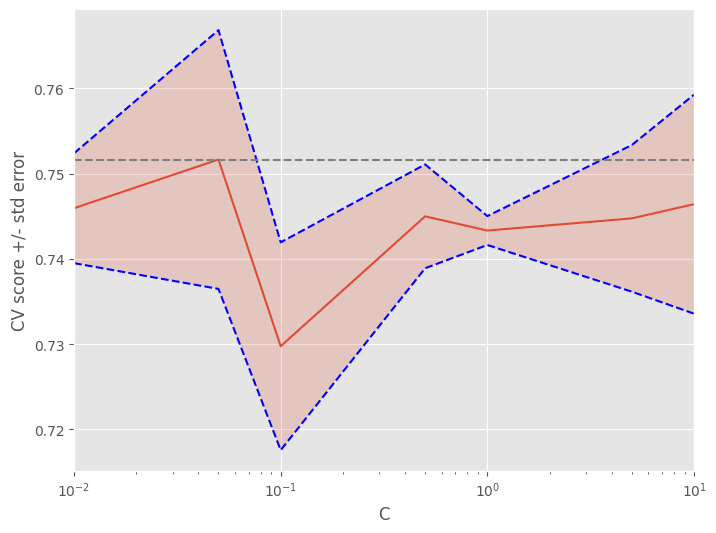

In [28]:
scores = clf_zeros.cv_results_["mean_test_score"]
scores_std = clf_zeros.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [ ]:
estimator = LogisticRegression()
clf_mean = GridSearchCV(estimator, param_grid, cv=3)
clf_mean.fit(X_train_mean, y_train)
clf_mean.best_estimator_

(0.01, 10)

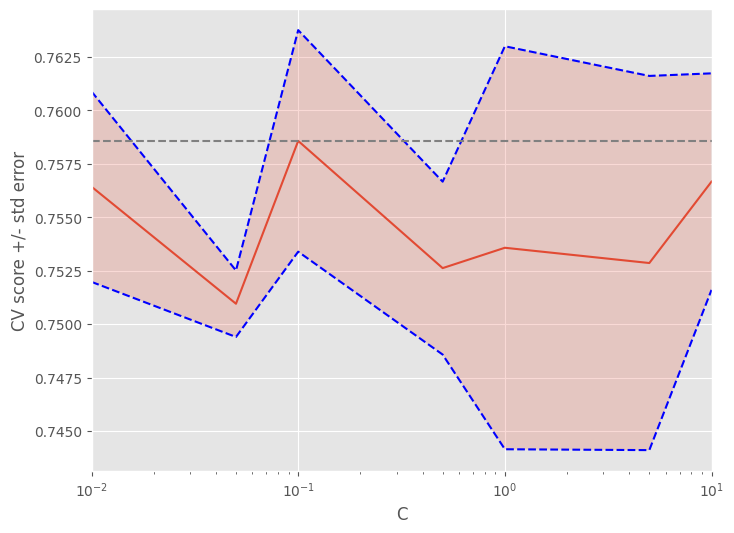

In [30]:
scores = clf_mean.cv_results_["mean_test_score"]
scores_std = clf_mean.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [31]:
y_zeros = clf_zeros.predict_proba(X_test_zeros)[:, 1]
roc_auc_zeros = roc_auc_score(y_test, y_zeros)
roc_auc_zeros

0.7844431300586152

In [32]:
y_mean = clf_mean.predict_proba(X_test_mean)[:, 1]
roc_auc_mean = roc_auc_score(y_test, y_mean)
roc_auc_mean

0.825034554186037

In [33]:
from sklearn.metrics import roc_curve

fpr_mean, tpr_mean, _ = roc_curve(y_test, y_mean)
fpr_zeros, tpr_zeros, _ = roc_curve(y_test, y_zeros)

Text(0.5, 1.0, 'ROC curve')

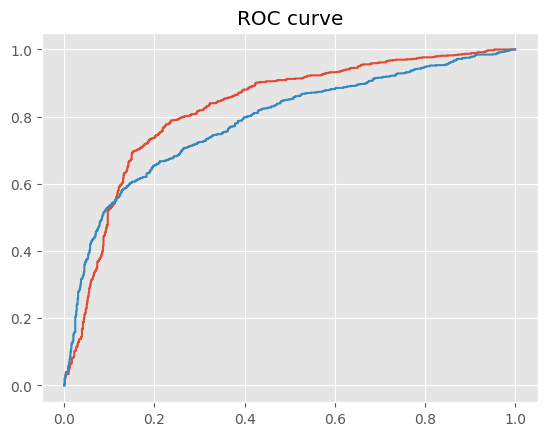

In [34]:
plt.plot(fpr_mean, tpr_mean)
plt.plot(fpr_zeros, tpr_zeros)
plt.title("ROC curve")

## Масштабирование вещественных признаков

Попробуем улучшить качество классификации. Посмотрим на данные:

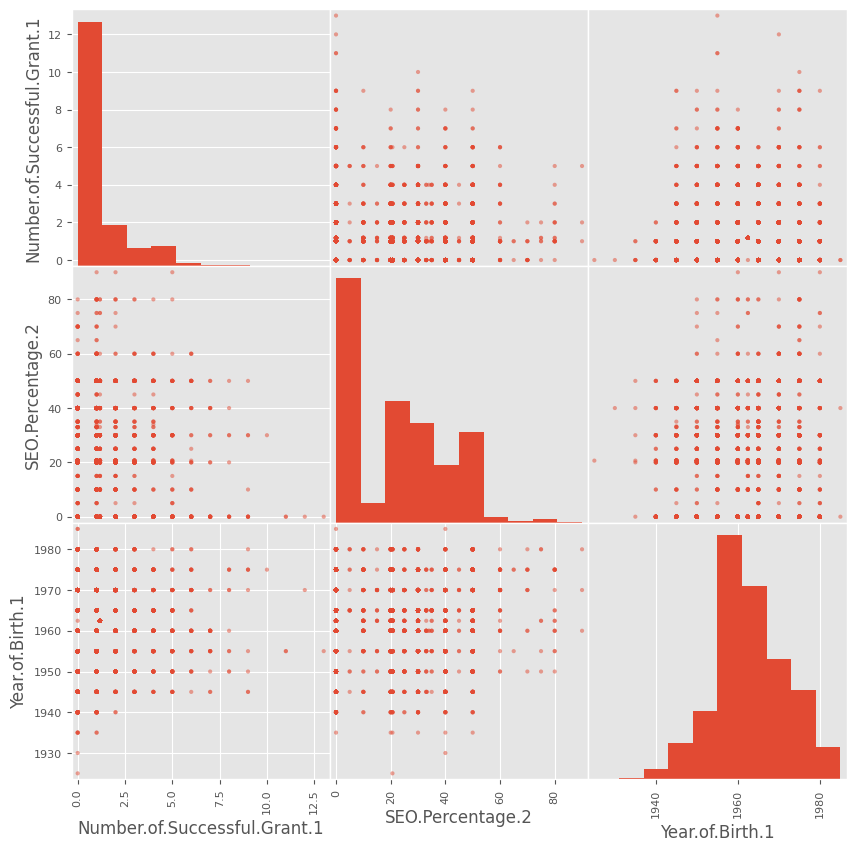

In [35]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_mean, columns=numeric_cols)
list_cols = ["Number.of.Successful.Grant.1", "SEO.Percentage.2", "Year.of.Birth.1"]
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y).

В таких случаях рекомендуется делать стандартизацию (масштабирование) признаков, чтобы они меньше отличались друг друга по модулю. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретируемость, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Масштабирование вещественных признаков

1. По аналогии с вызовом one-hot encoder применим масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс

        StandardScaler
   
   и методы

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_mean)
X_test_real_scaled = scaler.transform(X_test_real_mean)

## Сравнение признаковых пространств

Посмотрим на преобразованные данные:

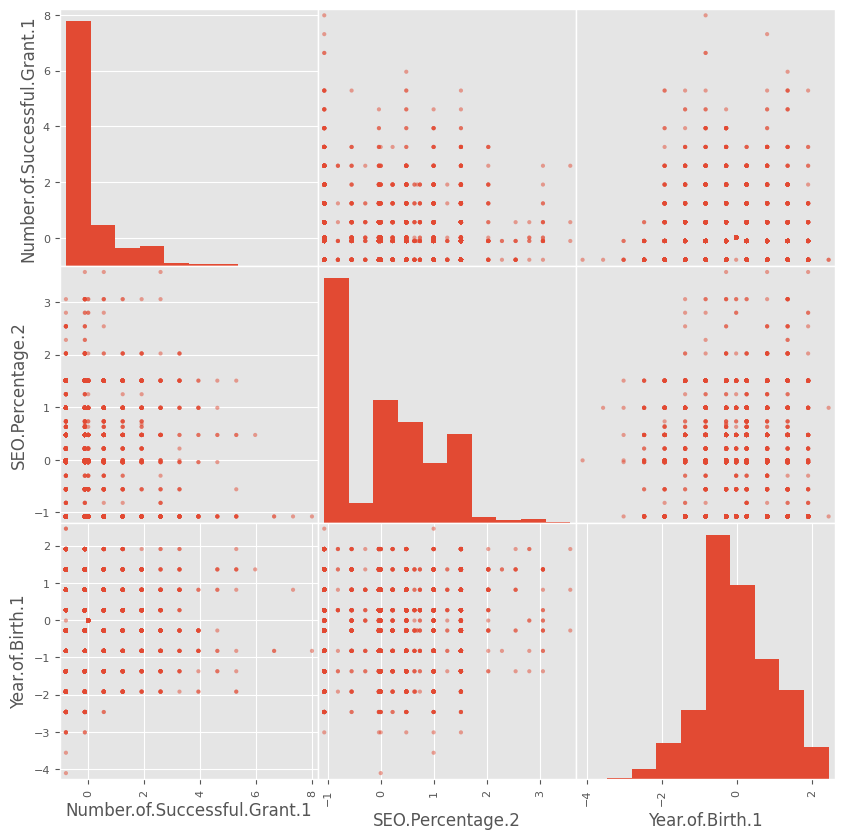

In [37]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ["Number.of.Successful.Grant.1", "SEO.Percentage.2", "Year.of.Birth.1"]
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков и их диаграммы рассеяния выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне.

Сравнение качества классификации до и после масштабирования вещественных признаков
1. Обучим ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверим, был ли найден оптимум accuracy по гиперпараметрам во время кросс-валидации.
3. Получим значение ROC AUC на тестовой выборке, сравним с лучшим результатом, полученными ранее.

In [38]:
X_train_scaled = np.concatenate((X_train_real_scaled, X_train_cat_oh), axis=1)
X_test_scaled = np.concatenate((X_test_real_scaled, X_test_cat_oh), axis=1)

estimator = LogisticRegression()
clf_scaled = GridSearchCV(estimator, param_grid, cv=3)
clf_scaled.fit(X_train_scaled, y_train)
clf_scaled.best_estimator_

(0.01, 10)

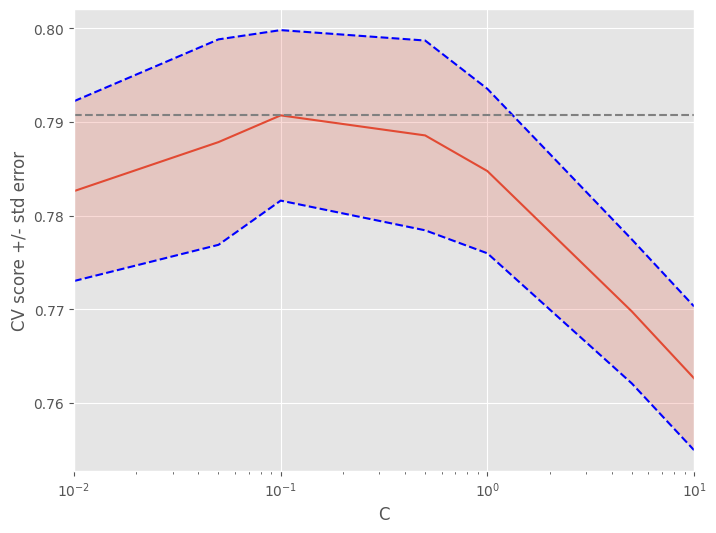

In [39]:
scores = clf_scaled.cv_results_["mean_test_score"]
scores_std = clf_scaled.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [ ]:
y_scaled = clf_scaled.predict_proba(X_test_scaled)[:, 1]
roc_auc_scaled = roc_auc_score(y_test, y_scaled)
roc_auc_scaled

0.888161370832926

## Балансировка классов

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Рассмотрим пример с выборками, сэмплированными из двух гауссиан. Их матожидания и матрицы ковариации заданы так, что истинная разделяющая поверхность должна проходить параллельно оси x. Поместим в обучающую выборку 20 объектов, сэмплированных из 1-й гауссианы, и 10 объектов из 2-й. После этого обучим на них линейную регрессию, и построим на графиках объекты и области классификации.

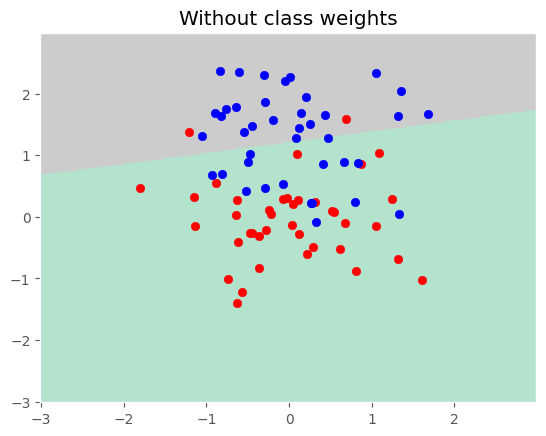

AUC: 0.911667


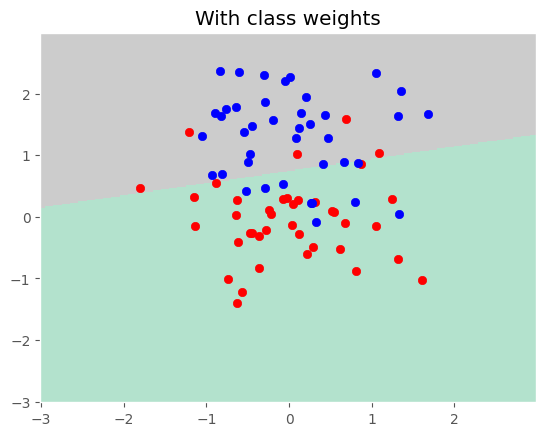

AUC: 0.906667


In [40]:
np.random.seed(0)

"""Сэмплируем данные из первой гауссианы"""
data_0 = np.random.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]], size=40)

"""И из второй"""
data_1 = np.random.multivariate_normal([0, 1], [[0.5, 0], [0, 0.5]], size=40)

"""На обучение берём 20 объектов из первого класса и 10 из второго"""
example_data_train = np.vstack([data_0[:20, :], data_1[:10, :]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])

"""На тест - 20 из первого и 30 из второго"""
example_data_test = np.vstack([data_0[20:, :], data_1[10:, :]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])

"""Задаём координатную сетку, на которой будем вычислять область классификации"""
xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))

"""Обучаем регрессию без балансировки по классам"""
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)

"""Строим предсказания регрессии для сетки"""
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:, 0], data_0[:, 1], color="red")
plt.scatter(data_1[:, 0], data_1[:, 1], color="blue")

"""Считаем AUC"""
auc_wo_class_weights = roc_auc_score(
    example_labels_test, optimizer.predict_proba(example_data_test)[:, 1]
)
plt.title("Without class weights")
plt.show()
print("AUC: %f" % auc_wo_class_weights)

"""Для второй регрессии в LogisticRegression передаём параметр class_weight='balanced'"""
optimizer = GridSearchCV(
    LogisticRegression(class_weight="balanced"), param_grid, cv=cv, n_jobs=-1
)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:, 0], data_0[:, 1], color="red")
plt.scatter(data_1[:, 0], data_1[:, 1], color="blue")
auc_w_class_weights = roc_auc_score(
    example_labels_test, optimizer.predict_proba(example_data_test)[:, 1]
)
plt.title("With class weights")
plt.show()
print("AUC: %f" % auc_w_class_weights)

Как видно, во втором случае классификатор находит разделяющую поверхность, которая ближе к истинной, т.е. меньше переобучается. Поэтому на сбалансированность классов в обучающей выборке всегда следует обращать внимание.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [ ]:
print(np.sum(y_train == 0))
print(np.sum(y_train == 1))

2316
1884


Видно, что нет.

Исправить ситуацию можно разными способами, мы рассмотрим два:
- давать объектам миноритарного класса больший вес при обучении классификатора (рассмотрен в примере выше),
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется.

## Балансировка классов
1. Обучим логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании.
2. Получим метрику ROC AUC на тестовой выборке.
3. Сбалансируем выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используем следующую комбинацию вызовов функций:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
   После этого добавим эти объекты в начало или конец обучающей выборки.

### Подход 1
давать объектам миноритарного класса больший вес при обучении классификатора

In [ ]:
estimator = LogisticRegression(class_weight="balanced")
clf_balance = GridSearchCV(estimator, param_grid, cv=3)
clf_balance.fit(X_train_scaled, y_train)
clf_balance.best_estimator_

(0.01, 10)

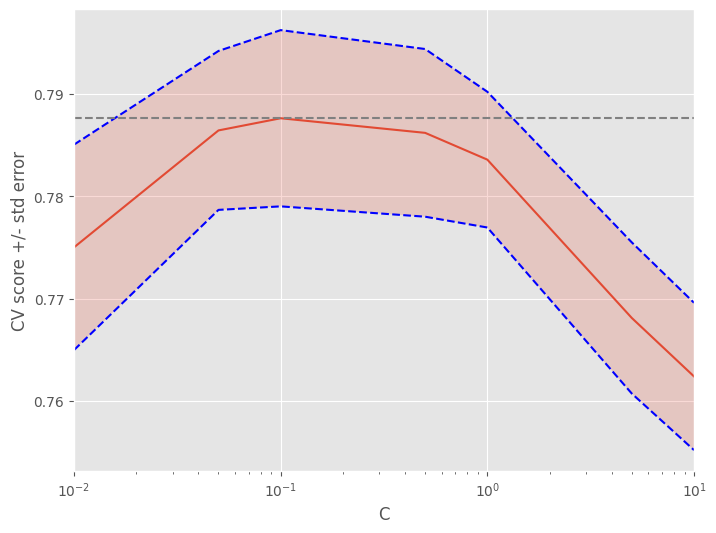

In [43]:
scores = clf_balance.cv_results_["mean_test_score"]
scores_std = clf_balance.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [44]:
y_balance = clf_balance.predict_proba(X_test_scaled)[:, 1]
roc_auc_balance = roc_auc_score(y_test, y_balance)
roc_auc_balance

0.8881824065057149

### Подход 2
досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется.

In [45]:
np.random.seed(0)
number_to_add = np.sum(y_train == 0) - np.sum(y_train == 1)
indices_to_add = np.random.randint(np.sum(y_train == 1), size=number_to_add)
X_train_to_add = X_train_scaled[y_train.to_numpy() == 1, :][indices_to_add, :]

In [46]:
X_train_sample = np.concatenate((X_train_scaled, X_train_to_add))
y_train_sample = np.concatenate((y_train, np.ones(number_to_add)))

In [47]:
X_train_sample.shape, y_train_sample.shape

((4632, 5582), (4632,))

In [ ]:
estimator = LogisticRegression()
clf_sample = GridSearchCV(estimator, param_grid, cv=3)
clf_sample.fit(X_train_sample, y_train_sample)
clf_sample.best_estimator_

(0.01, 10)

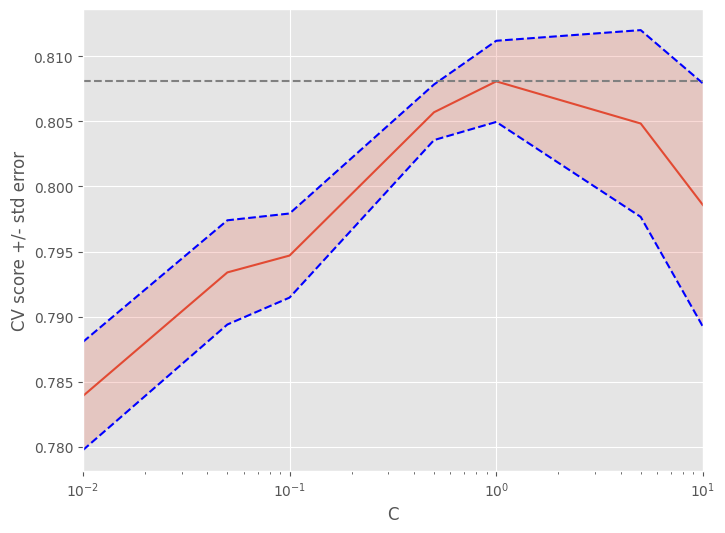

In [49]:
scores = clf_sample.cv_results_["mean_test_score"]
scores_std = clf_sample.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [50]:
y_sample = clf_sample.predict_proba(X_test_scaled)[:, 1]
roc_auc_sample = roc_auc_score(y_test, y_sample)
roc_auc_sample

0.8848117492894273

## Стратификация выборок

Рассмотрим ещё раз пример с выборками из нормальных распределений. Посмотрим ещё раз на качество классификаторов, получаемое на тестовых выборках:

In [51]:
print("AUC ROC for classifier without weighted classes", auc_wo_class_weights)
print("AUC ROC for classifier with weighted classes: ", auc_w_class_weights)

AUC ROC for classifier without weighted classes 0.9116666666666666
AUC ROC for classifier with weighted classes:  0.9066666666666666


Насколько эти цифры реально отражают качество работы алгоритма, если учесть, что тестовая выборка так же несбалансирована, как обучающая?
Мы уже знаем, что алгоритм логистический регрессии чувствителен к балансировке классов в обучающей выборке, т.е. в данном случае на тесте он будет давать заведомо заниженные результаты. Метрика классификатора на тесте имела бы гораздо больший смысл, если бы объекты были разделы в выборках поровну: по 20 из каждого класса на обучени и на тесте. Переформируем выборки и подсчитаем новые ошибки:

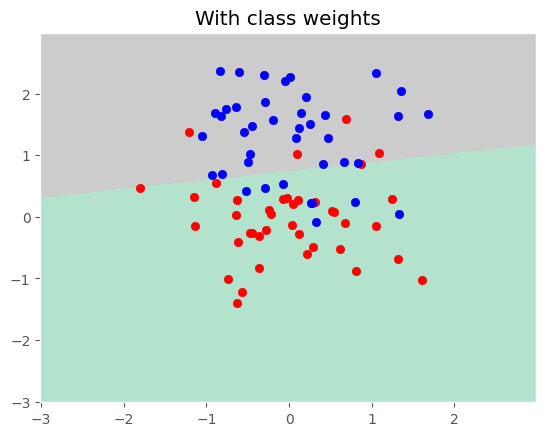

AUC ROC for stratified samples:  0.9125


In [52]:
"""Разделим данные по классам поровну между обучающей и тестовой выборками"""

example_data_train = np.vstack([data_0[:20, :], data_1[:20, :]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:, :], data_1[20:, :]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])

"""Обучим классификатор"""
optimizer = GridSearchCV(
    LogisticRegression(class_weight="balanced"), param_grid, cv=cv, n_jobs=-1
)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:, 0], data_0[:, 1], color="red")
plt.scatter(data_1[:, 0], data_1[:, 1], color="blue")
auc_stratified = roc_auc_score(
    example_labels_test, optimizer.predict_proba(example_data_test)[:, 1]
)
plt.title("With class weights")
plt.show()
print("AUC ROC for stratified samples: ", auc_stratified)

Как видно, после данной процедуры ответ классификатора изменился незначительно, а вот качество увеличилось. При этом, в зависимости от того, как вы разбили изначально данные на обучение и тест, после сбалансированного разделения выборок итоговая метрика на тесте может как увеличиться, так и уменьшиться, но доверять ей можно значительно больше, так как она построена с учётом специфики работы классификатора. Данный подход является частным случаем так называемого метода стратификации.

## Стратификация выборки

1. По аналогии с тем, как это было сделано в начале лекции, разобьем выборки X_real_mean и X_cat_oh на обучение и тест, передавая в функцию
       train_test_split(...)
   дополнительный параметр
       stratify=y
   Также обязательно передаем в функцию переменную random_state=0.
2. Выполним масштабирование новых вещественных выборок, обучим классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов.
3. Оценим качество классификатора метрике AUC ROC на тестовой выборке.

In [53]:
# строим разбиение выборки
(X_train_real_stratify, X_test_real_stratify, y_train_stratify, y_test_stratify) = (
    train_test_split(X_real_mean, y, test_size=0.3, random_state=0, stratify=y)
)

(X_train_cat_stratify, X_test_cat_stratify) = train_test_split(
    X_cat_oh, test_size=0.3, random_state=0, stratify=y
)

In [54]:
scaler = StandardScaler()
X_train_real_stratify_scaled = scaler.fit_transform(X_train_real_stratify)
X_test_real_stratify_scaled = scaler.transform(X_test_real_stratify)

In [55]:
X_train_stratify = np.concatenate(
    [X_train_real_stratify_scaled, X_train_cat_stratify], axis=1
)
X_test_stratify = np.concatenate(
    [X_test_real_stratify_scaled, X_test_cat_stratify], axis=1
)

X_train_stratify.shape, X_test_stratify.shape

((4200, 5582), (1800, 5582))

In [ ]:
estimator = LogisticRegression(class_weight="balanced")
clf_stratify = GridSearchCV(estimator, param_grid, cv=3)
clf_stratify.fit(X_train_stratify, y_train_stratify)
clf_stratify.best_estimator_

(0.01, 10)

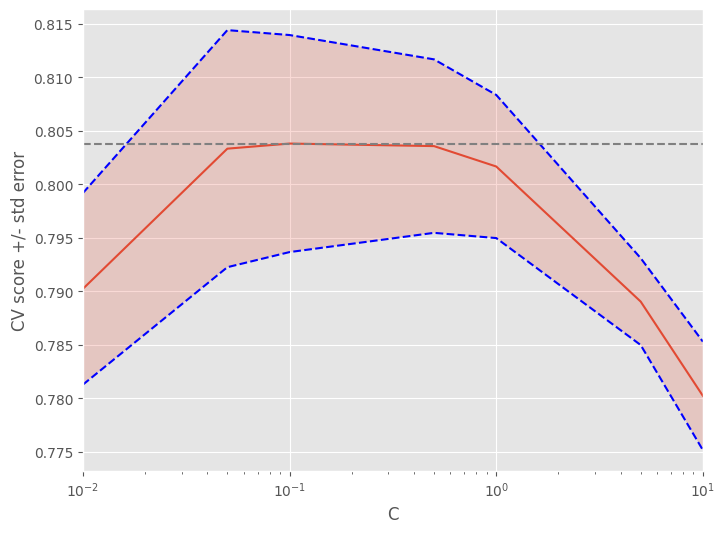

In [57]:
scores = clf_stratify.cv_results_["mean_test_score"]
scores_std = clf_stratify.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [ ]:
y_stratify = clf_stratify.predict_proba(X_test_stratify)[:, 1]
roc_auc_stratify = roc_auc_score(y_test_stratify, y_stratify)
roc_auc_stratify

0.876066031774464

Основные этапы предобработки данных для линейных классификаторов:
- обработка пропусков
- перекодирование категориальных признаков
- стратификация
- балансировка классов
- масштабирование

Эти действия с данными рекомендуется проводить при каждом использовании линейных методов, да и многих других.

## Трансформация признаков

Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самый простой — полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D}, x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Рассмотрим принцип работы данных признаков на данных, сэмплированных их гауссиан:

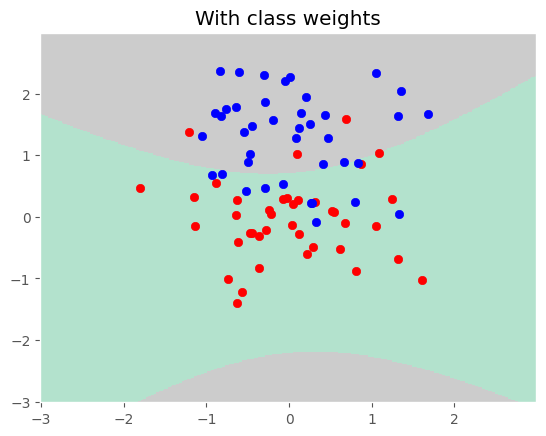

In [58]:
from sklearn.preprocessing import PolynomialFeatures

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2)

"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)

"""Обращаем внимание на параметр fit_intercept=False"""
optimizer = GridSearchCV(
    LogisticRegression(class_weight="balanced", fit_intercept=False),
    param_grid,
    cv=cv,
    n_jobs=-1,
)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(
    xx.shape
)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:, 0], data_0[:, 1], color="red")
plt.scatter(data_1[:, 0], data_1[:, 1], color="blue")
plt.title("With class weights")
plt.show()

Видно, что добавление полиномов от признаков позволяет строить нелинейные разделяющие поверхности, которые могут лучше подстраиваться под данные и находить более сложные зависимости.

С другой стороны, с увеличением степени $p$ из-за быстрого роста числа признаков модель будет быстрее переобучаться. Число признаков в новой модели:

In [59]:
print(example_data_train.shape)
example_data_train[0, :]

(40, 2)


array([1.24737338, 0.28295388])

In [60]:
print(example_data_train_poly.shape)
example_data_train_poly[0, :]

(40, 6)


array([1.        , 1.24737338, 0.28295388, 1.55594034, 0.35294913,
       0.0800629 ])

Рассмотрим пример с $p=11$:

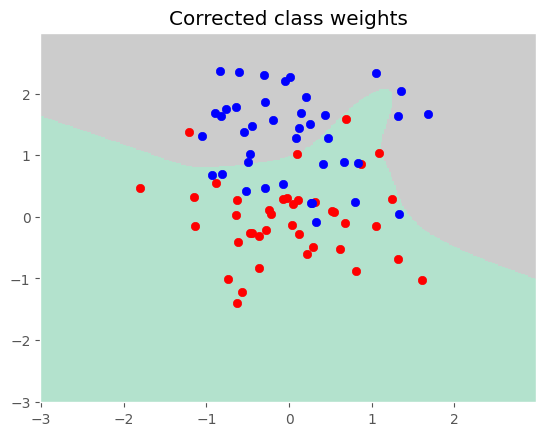

In [61]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(
    LogisticRegression(class_weight="balanced", fit_intercept=False),
    param_grid,
    cv=cv,
    n_jobs=-1,
)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(
    xx.shape
)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:, 0], data_0[:, 1], color="red")
plt.scatter(data_1[:, 0], data_1[:, 1], color="blue")
plt.title("Corrected class weights")
plt.show()

Очень плохо! Количество признаков здесь:

In [ ]:
print(example_data_train_poly.shape)

(40, 78)


Очень много!

## Трансформация вещественных признаков

1. По аналогии с примером добавим в модель квадраты вещественных признаков.
2. Построим логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Обращаем внимание, что среди квадратов признаков уже присутствует столбец, все значения которого равны 1, поэтому обучать дополнительно значение $b$ не нужно, его функцию выполняет один из весов $w$. В связи с этим, во избежание линейной зависимости признаков, в вызов класса логистической регрессии требуется передавать параметр fit_intercept=False. Для обучения используем стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.
3. Получим AUC ROC на тесте и сравните данный результат с использованием обычных признаков.

In [62]:
transform = PolynomialFeatures(2)
X_train_real_poly = transform.fit_transform(X_train_real_stratify)
X_test_real_poly = transform.transform(X_test_real_stratify)

scaler = StandardScaler()
X_train_real_poly_scaled = scaler.fit_transform(X_train_real_poly)
X_test_real_poly_scaled = scaler.transform(X_test_real_poly)

X_train_poly = np.concatenate([X_train_real_poly_scaled, X_train_cat_stratify], axis=1)
X_test_poly = np.concatenate([X_test_real_poly_scaled, X_test_cat_stratify], axis=1)

In [63]:
estimator = LogisticRegression(fit_intercept=False, class_weight="balanced")
clf_poly = GridSearchCV(estimator, param_grid, cv=3)
clf_poly.fit(X_train_poly, y_train_stratify)
clf_poly.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', fit_intercept=False)

(0.01, 10)

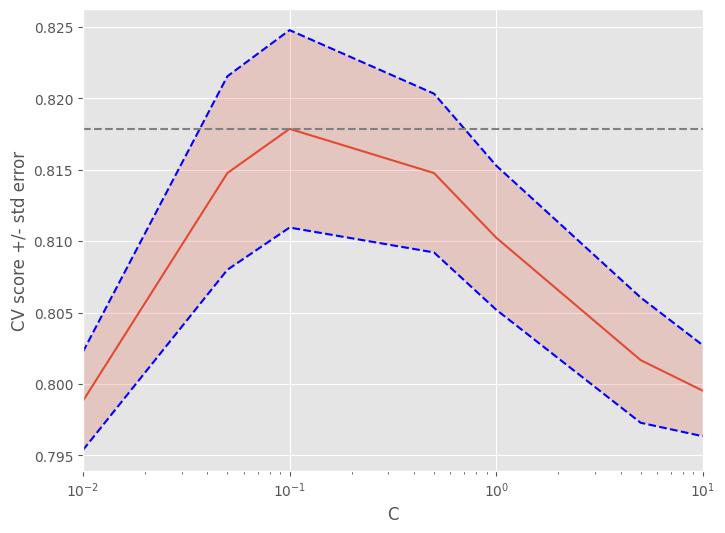

In [65]:
scores = clf_poly.cv_results_["mean_test_score"]
scores_std = clf_poly.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [66]:
y_poly = clf_poly.predict_proba(X_test_poly)[:, 1]
roc_auc_poly = roc_auc_score(y_test_stratify, y_poly)
roc_auc_poly

0.8949461137730808

## Lasso
C логистической регрессией можно использовать и регуляризатор $L_2$ (Lasso), который будет приводить к отбору признаков. Давайте попробуем применить $L_2$-регуляцию к исходным признакам и проинтерпретировать полученные результаты (применение отбора признаков к полиномиальным так же можно успешно применять, но в нём уже будет отсутствовать компонента интерпретации, так как интерпретировать полиномы от признаков может быть довольно сложно). Для вызова логистической регрессии с $L_2$-регуляризацией достаточно передать параметр penalty='l2' в инициализацию класса.

## Отбор признаков при помощи Lasso
1. Обучим регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получим ROC AUC регрессии, сравним его с предыдущими результатами.
3. Найдем номера вещественных признаков, которые имеют нулевые веса в итоговой модели.

In [ ]:
estimator = LogisticRegression(
    fit_intercept=False, penalty=None, class_weight="balanced"
)
clf_lasso = GridSearchCV(estimator, param_grid, cv=3)
clf_lasso.fit(X_train_poly, y_train_stratify)
clf_lasso.best_estimator_

(0.01, 10)

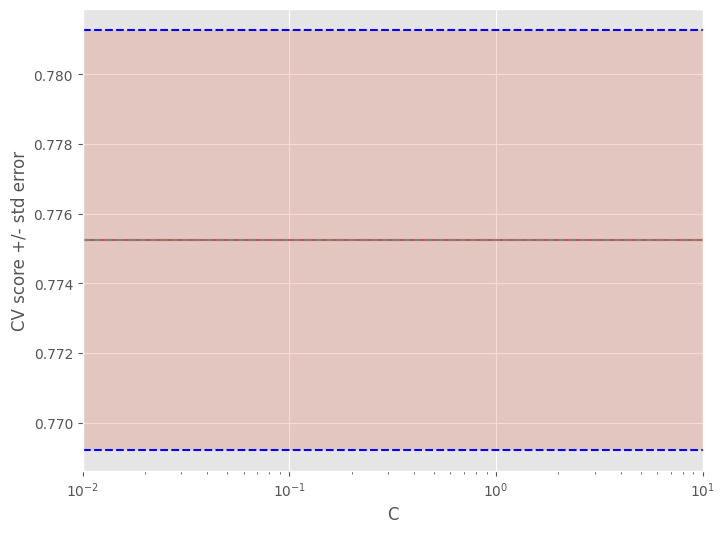

In [68]:
scores = clf_lasso.cv_results_["mean_test_score"]
scores_std = clf_lasso.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [69]:
y_poly_lasso = clf_lasso.predict_proba(X_test_poly)[:, 1]
roc_auc_lasso = roc_auc_score(y_test_stratify, y_poly_lasso)
roc_auc_lasso

0.8682940755004255

In [71]:
lasso_coefs = clf_lasso.best_estimator_.coef_
zero_coefs = np.where(lasso_coefs == 0)[1].tolist()

In [72]:
X_test_poly.shape

(1800, 5688)

## Удаляем незначащие признаки

In [73]:
X_test_poly_cleared = np.delete(X_test_poly, zero_coefs, 1)
X_train_poly_cleared = np.delete(X_train_poly, zero_coefs, 1)

In [ ]:
estimator = LogisticRegression(
    fit_intercept=False, penalty="l2", class_weight="balanced"
)
clf_lasso = GridSearchCV(estimator, param_grid, cv=3)
clf_lasso.fit(X_train_poly_cleared, y_train_stratify)
clf_lasso.best_estimator_

(0.01, 10)

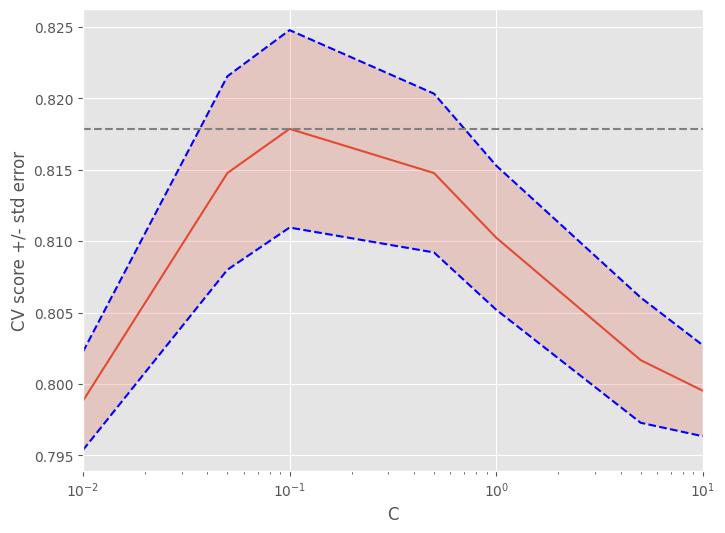

In [75]:
scores = clf_lasso.cv_results_["mean_test_score"]
scores_std = clf_lasso.cv_results_["std_test_score"]

plt.figure().set_size_inches(8, 6)
plt.semilogx(cs, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(cs, scores + std_error, "b--")
plt.semilogx(cs, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(cs, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([cs[0], cs[-1]])

In [76]:
y_poly_lasso = clf_lasso.predict_proba(X_test_poly_cleared)[:, 1]
roc_auc_lasso = roc_auc_score(y_test_stratify, y_poly_lasso)
roc_auc_lasso

0.8949461137730808

## Окончательный пайплайн обучения модели

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold

In [78]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("polynomial_featurer", PolynomialFeatures(2)),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False),
        )
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [83]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("selector1", VarianceThreshold()),
        ("selector2", SelectPercentile(percentile=20)),
        (
            "classifier",
            LogisticRegression(
                fit_intercept=True, penalty="l2", class_weight="balanced", C=0.1
            ),
        ),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

clf.fit(X_train, y_train)
print(
    "model score: %.3f"
    % roc_auc_score(y_test.to_numpy(), clf.predict_proba(X_test)[:, 1])
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


model score: 0.894


In [84]:
from sklearn.metrics import f1_score

f1_score(y_test.to_numpy(), clf.predict(X_test), average="weighted")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 21, 23, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.814587544815887